## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

In [116]:
import pandas as pd
import holidays
from darts import TimeSeries

# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
weather_data= pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";",skiprows=9)

# Change the timestamp following the dataseries for DARTS
load2023['Time (UTC)'] = load2023['Time (UTC)'].str.split(' - ').str[0]
# Delete the initial day ahead forecast data
load2023 = load2023.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3',axis=1)   
# Change the name to simple name
load2023 = load2023.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
# Convert 'time' to datetime for easier splitting
load2023['datetime'] = pd.to_datetime(load2023['completetime'], format='%d.%m.%Y %H:%M')
load2023 = load2023.drop(['completetime'], axis=1)
# Adding the column temprature
load2023['Temprature']=weather_data['Lufttemperatur']
# Adding day type
load2023['Day_of_week'] = load2023['datetime'].dt.dayofweek
load2023['Hour_of_day'] = load2023['datetime'].dt.hour
# Adding Holidays
Sweden_holidays = holidays.CountryHoliday('SE')
load2023['Holidays'] = [int(date in Sweden_holidays) for date in load2023.datetime]

# Reorder the column
load2023 = load2023[['datetime', 'Load','Temprature','Day_of_week', 'Hour_of_day', 'Holidays']]



# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load2023,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load2023,
    time_col="datetime",
    value_cols=["Temprature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load2023,
    time_col="datetime",
    value_cols=["Holidays"]
)

print(series)



load2023


<TimeSeries (DataArray) (datetime: 8760, component: 1, sample: 1)> Size: 70kB
array([[[ 8943.]],

       [[ 8929.]],

       [[ 8887.]],

       ...,

       [[11035.]],

       [[10831.]],

       [[10722.]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * component  (component) <U4 16B 'Load'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


,datetime,Load,Temprature,Day_of_week,Hour_of_day,Holidays
0,2023-01-01 00:00:00,8943,3.6,6,0,1
1,2023-01-01 01:00:00,8929,3.0,6,1,1
2,2023-01-01 02:00:00,8887,2.6,6,2,1
3,2023-01-01 03:00:00,8859,2.4,6,3,1
4,2023-01-01 04:00:00,8880,2.0,6,4,1
...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,11561,-1.9,6,19,1
8756,2023-12-31 20:00:00,11276,-1.7,6,20,1
8757,2023-12-31 21:00:00,11035,-1.5,6,21,1
8758,2023-12-31 22:00:00,10831,-1.9,6,22,1


In [130]:
# Set aside the last 2 as a validation series
train, val = Load[:-144], Load[-144:]

Fit an exponential smoothing model, and make a (probabilistic) prediction over the validation series’ duration:

In [134]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=8700)

c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Plot the median, 5th and 95th percentiles:

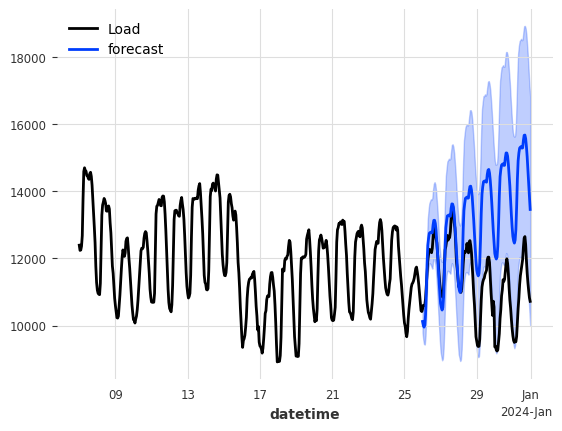

In [139]:
import matplotlib.pyplot as plt

# Slice the TimeSeries for the last 1 months (Oct 1, 2023 - Dec 31, 2023)
last_3_months = Load.slice(
    start_ts=pd.Timestamp('2023-12-07 00:00:00'),
    end_ts=pd.Timestamp('2023-12-31 23:00:00')
)

last_3_months.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()